# Tomo_1_index_minor_phase
## Tomographic indexing notebook, with optimizations for minor phases
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to find good grain orientations from a 4D merge of your peak data.  
This means your peaks have been merged across omega (rotation of the sample around the rotation axis) and dty (translation of the sample across the beam).  

This notebook is optimised for a weaker minor phase in a larger major phase sample.  

This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

The notebooks are written with all the parameters in the first cell.
We will see how to tune these parameters along the notebook.

For now, change : 
1. the dataset name (*dset_path*)
2. the major phase name (*major_phase_strs*), this is a list [] because you may want to filter the major phase and other minor phases you already indexed
3. the minor phase name (*minor_phase_str*)

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( os.path.join( os.environ['HOME'],'Code', 'Tutorial', 'SCRIPTS'), 'ImageD11' )# ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = '../FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5'

# phase names
major_phase_strs = ['Fe']
minor_phase_str = 'Au'

# peak filtration parameters
min_frames_per_peak = 0
# whether to filter out major phase peaks before trying to index
remove_major_phase_peaks = True
major_phase_cf_dstol = 0.005
minor_phase_cf_frac = 0.9975
minor_phase_cf_dsmax = 1.594
minor_phase_cf_dstol = 0.005

# indexing
rings_for_gen = [0, 4, 5]

# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13]

# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9]
# the max number of UBIs we can find per pair of rings
max_grains = 1000

peak_assign_tol = 0.025

# Setting path via: 
sys.path.insert(0, /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11 )


# Running from: /home/esrf/ljegou/Code/Tutorial/SCRIPTS/ImageD11/ImageD11/__init__.py


In [3]:
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.nbGui.nb_utils as utils
from ImageD11.peakselect import select_ring_peaks_by_intensity, remove_peaks_from_phases

# %matplotlib ipympl

# Load data
1. The dataset
2. The phases
3. The segmented peaks

## Dataset

In [4]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
Specify the path to the parameter file.

If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [5]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'B2': B2 | [ 3.8867  3.8867  3.8867 90.     90.     90.    ] | 221,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

Now we need to decide which are our 'major' phases, which we will remove from our peaks before indexing.

In [6]:
major_phase_unitcells = [ds.phases.unitcells[mps] for mps in major_phase_strs]
print(*major_phase_unitcells)
minor_phase_unitcell = ds.phases.unitcells[minor_phase_str]
print(minor_phase_unitcell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229
Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225


## Peaks
Loading the peaks that have beem segmented in @@@ref to 0_segmentation@@@ as a columnfile (*cf_4d*)

In [7]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)  # computes geometry, needed for filtration
for major_phase_unitcell in major_phase_unitcells:
    major_phase_unitcell.makerings(cf_4d.ds.max())
minor_phase_unitcell.makerings(cf_4d.ds.max())

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250626_LJ/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_4d.h5
Reading your columnfile in hdf format


### Optionally remove some noisy peaks
You can filter peaks that do not appear on a minimum number of frame.
`min_frames_per_peaks = 0`

In [8]:
if min_frames_per_peak > 0:
    cf_4d.filter(cf_4d['npk2d'] > min_frames_per_peak)

# Filtration
## (optional) remove major phase peaks
- `cf_4d`: all the peaks
- `major_phase_cf_dstol`: it is the tolerance around the predicted reflection from the majorphase where the peaks will be removed.
- `major_phase_unitcells`: unitcell of the major phase

In [9]:
if remove_major_phase_peaks:
    cf_4d = remove_peaks_from_phases(cf_4d, major_phase_cf_dstol, major_phase_unitcells)

## Filter by intensity
Now we are filtering our peaks (`cf_4d`) to select only the strongest ones for indexing purposes only!  

1. We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
2. We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.
   
`minor_phase_cf_dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`minor_phase_cf_dsmax`: The maximum $d^{*}$ value ; peaks that have a $d^{*}$ below this value will be kept for indexing. 6-8 rings max are normally sufficient.   
`minor_phase_cf_frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

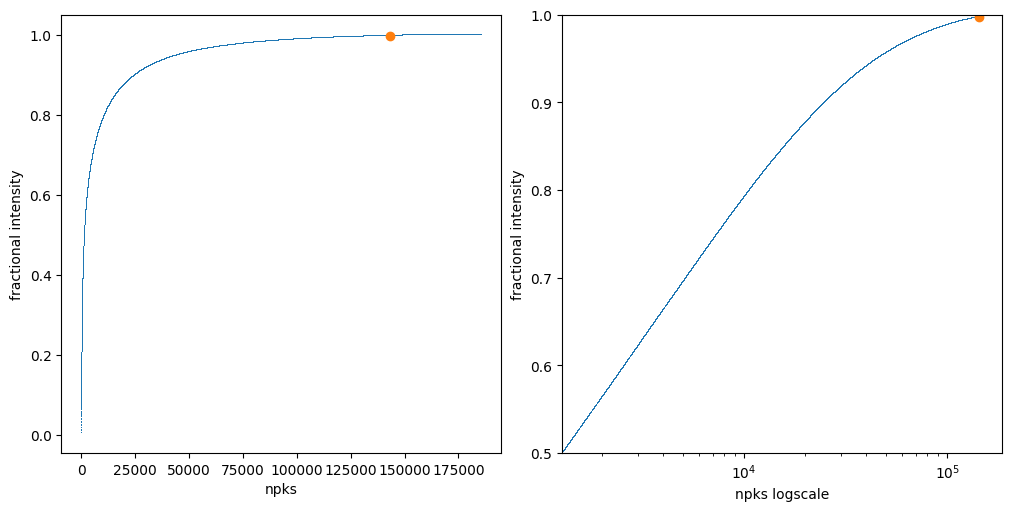

Filtered 143424 peaks from 513331


In [10]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=minor_phase_cf_frac, dsmax=minor_phase_cf_dsmax, dstol=minor_phase_cf_dstol, ucell=minor_phase_unitcell, doplot=0.5)

All the peaks are plotted as a function of their intensity, and the strongest ones that are kept for indexing are highlighted in orange.
By zooming aroung one single peak, it is possible to refine the value of `minor_phase_cf_dstol`.

If peaks from the major and minor phase are very close to each other, the filtration of the major phase peaks will also remove peaks coming from the minor phase. 
During the indexing, it does not matter as long as you still have enough peaks to index the grains (= rings that differs from the major phase reflection).

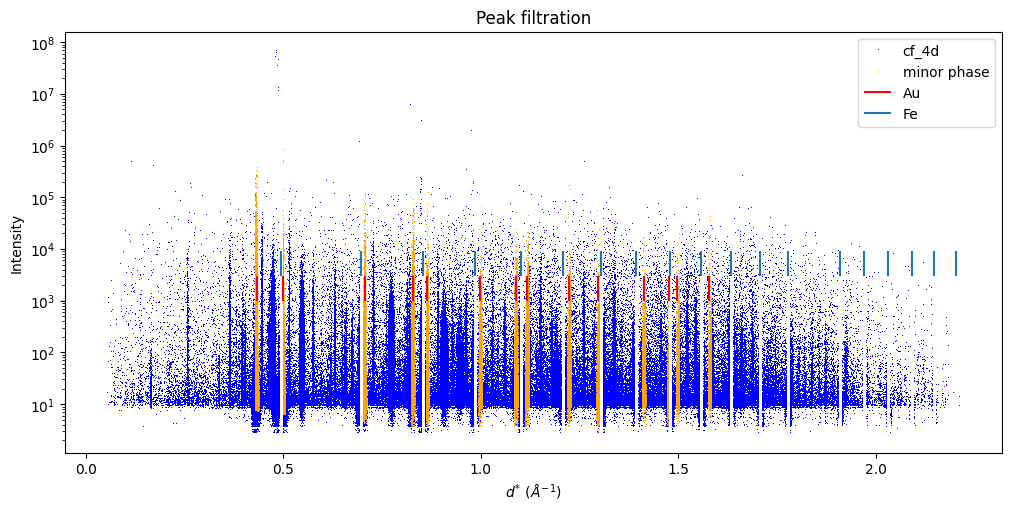

In [11]:
minor_phase_unitcell.makerings(cf_strong.ds.max())
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d',c='blue')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='minor phase',c='orange')
ax.vlines(minor_phase_unitcell.ringds, 1e3, 3e3, color='red', label=minor_phase_unitcell.name)
for inc, major_phase_unitcell in enumerate(major_phase_unitcells):
    ax.vlines(major_phase_unitcell.ringds, 3e3*(3**inc), 3e3*(2**inc)*3, color=plt.color_sequences['tab20'][inc], label=major_phase_unitcell.name)
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
## Ring assignment
For the current phase cell parameters and the selected strong peaks (*cf_strong*), the multiplicity of each reflection and the number of peaks to index is prompted.

In [12]:
indexer = ImageD11.indexing.indexer_from_colfile_and_ucell(cf_strong, minor_phase_unitcell)
indexer.ds_tol = minor_phase_cf_dstol
ImageD11.indexing.loglevel = 1
indexer.assigntorings()
ImageD11.indexing.loglevel = 3
print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.01651424  0.32280078 -0.28214482]
 [-0.1447915  -0.84005254  0.1310461 ]
 [-0.01696531  0.41850492 -0.27376294]
 ...
 [ 0.0310081   0.39445751  0.16872218]
 [-0.00794657  0.33277132 -0.27378634]
 [-0.00475931  0.32720524 -0.27866476]] (143424, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.584157
info: Ring assignment array shape (143424,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 13  ( -6,  0, -2)   24   2353       0     2353    96     24  25.97
info: Ring 12  ( -2, -4, -4)   30   3786       0     3786   124     30  24.62
info: Ring 11  ( -1, -5, -3)   48   1101       0     1101    22     48  24.27
info: Ring 10  ( -4,  0, -4)   12   3083       0     3083   254     12  23.19
info: Ring 9   ( -3, -3, -3)   32   7394       0     7394   228     32  21.28
info: Ring 8   ( -2, -2, -4)   24   7295       0     7295   300     24  20.05
info: Ring 7   ( -2,  0, -4)   24   8858       0     8858   365     24 

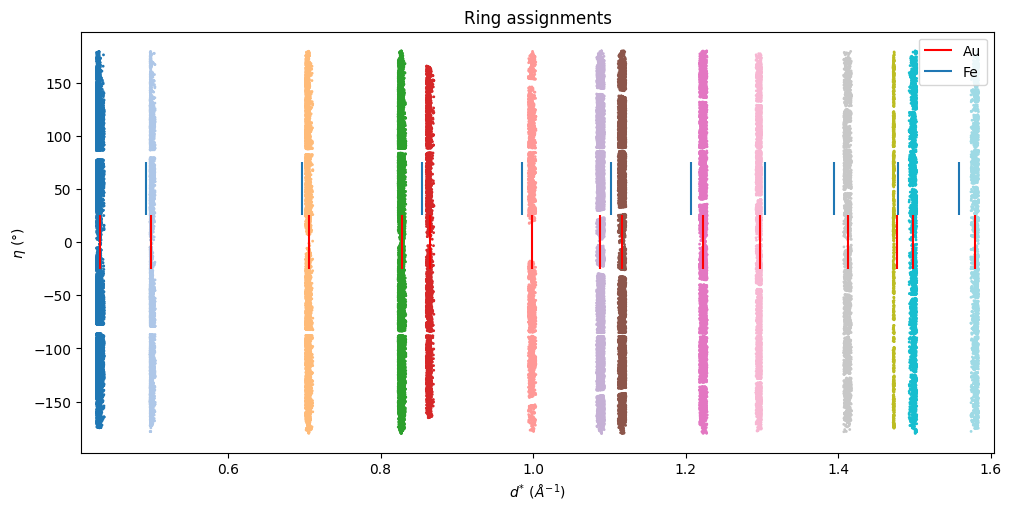

In [13]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
ax.scatter(indexer.colfile.ds[::skip], indexer.colfile.eta[::skip], c=indexer.ra[::skip]%20, cmap='tab20', s=1)
ax.vlines(minor_phase_unitcell.ringds, -25, 25, color='red', label=minor_phase_unitcell.name)
for inc, major_phase_unitcell in enumerate(major_phase_unitcells):
    ax.vlines(major_phase_unitcell.ringds, -25+(50*(inc+1)), 25+(50*(inc+1)), color=plt.color_sequences['tab20'][inc], label=major_phase_unitcell.name)
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', xlim=(min(minor_phase_unitcell.ringds[0], cf_strong.ds.min()) - 0.02, cf_strong.ds.max() + 0.02), title='Ring assignments')
ax.legend(loc='upper right')
plt.show()

Seven parameters are tunable for this step : 
- `minor_phase_cf_dstol` has been defined earlier,
- `rings_for_gen` is a list of integers. It refers to the theoretical reflections that will be use to generate grain candidates. For a fast indexing, it is smarter to select rings with a low multiplicity.
- `rings_for_scoring` is a list of integers. It refers to the theoretical reflections that will be use to score the grain candidates. `rings_for_gen` has to be included in `rings_for_scoring`.
- `hkl_tols_seq` is a list of floats. It refers to the tolerances around the *hkl* to assess if a peak belongs to a grain or not. 
- `fracs` is a list of floats. It refers to the number of peaks a grain needs to have to accept it, as a fraction of the number of peaks a real grain is expected to have. 
- `cosine_tol` is a float number. @@@ what is this @@@
- `max_grains` is an integer. The maximum number of grains that can be indexed (it highly unlikely to have more than 1000 grains in the major phase today 06/2025).

The indexing will be executed in a loop such as : 
```
for f in fracs:
    for khl in hkl_tols_seq:
        Do_indexing
```
Note that if $n$ peaks are assigned to a grain during the first round of indexing, these peaks will be removed from all the other indexing steps. 

Minor phases are often composed of a lot of very small grains, it is normal to index hundreds of grains.

In [14]:
cosine_tol = np.cos(np.radians(90 - ds.ostep))
grains, indexer = utils.do_index(cf=cf_strong,
                                 unitcell=minor_phase_unitcell,
                                dstol=minor_phase_cf_dstol,
                                forgen=rings_for_gen,
                                foridx=rings_for_scoring,
                                hkl_tols=hkl_tols_seq,
                                fracs=fracs,
                                cosine_tol=cosine_tol,
                                max_grains=max_grains
)
for ginc, g in enumerate(grains):
    g.gid = ginc
print(f'Found {len(grains)} grains!')

196 peaks expected
Trying these rings (counts, multiplicity, ring number): [(3810, 6, 5), (6391, 8, 4), (41537, 8, 0)]


KeyboardInterrupt: 

# Results

Let's take a look at the results. Firstly, it is possible to compute the average cell parameters of all indexed grains. 
If the average parameters of the unit cell are far from the one used to do the indexing, it is possible to update them in the parameter file, and redo the indexing from scratch.

Median unit cell: [ 4.00583149  4.01067433  4.01553698 89.93764345 90.00260765 90.06583955]


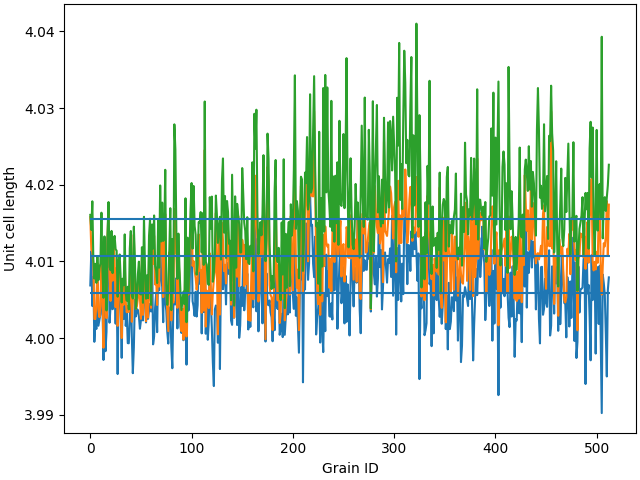

In [15]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel='Grain ID', ylabel='Unit cell length')
plt.show()

In [16]:
utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

Scoring and assigning 513 grains


  0%|          | 0/513 [00:00<?, ?it/s]

The overall results for the minor phase often tends to look worse than the major phase. A lot of strong peaks are still unassigned and the number of peaks per grains is not as high.
Besides, the sinograms also look a bit messier.

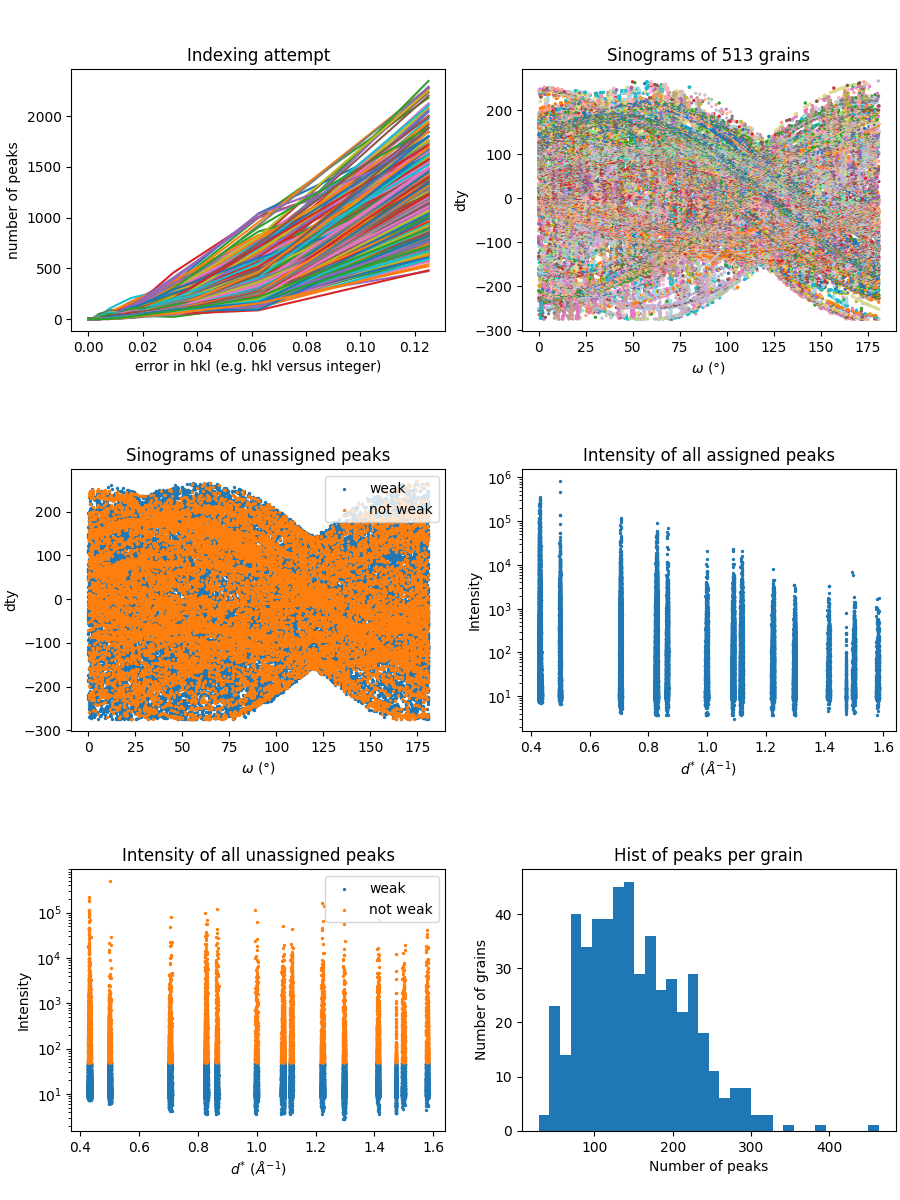

In [17]:
utils.plot_index_results(indexer, cf_strong, 'Indexing attempt')

Finally, it is possible to visualize some sinograms individually. Here the impact of `peak_assign_tol` is clearly visible. When it is increased too much, more noisy peaks start to appear on the sinogram. 


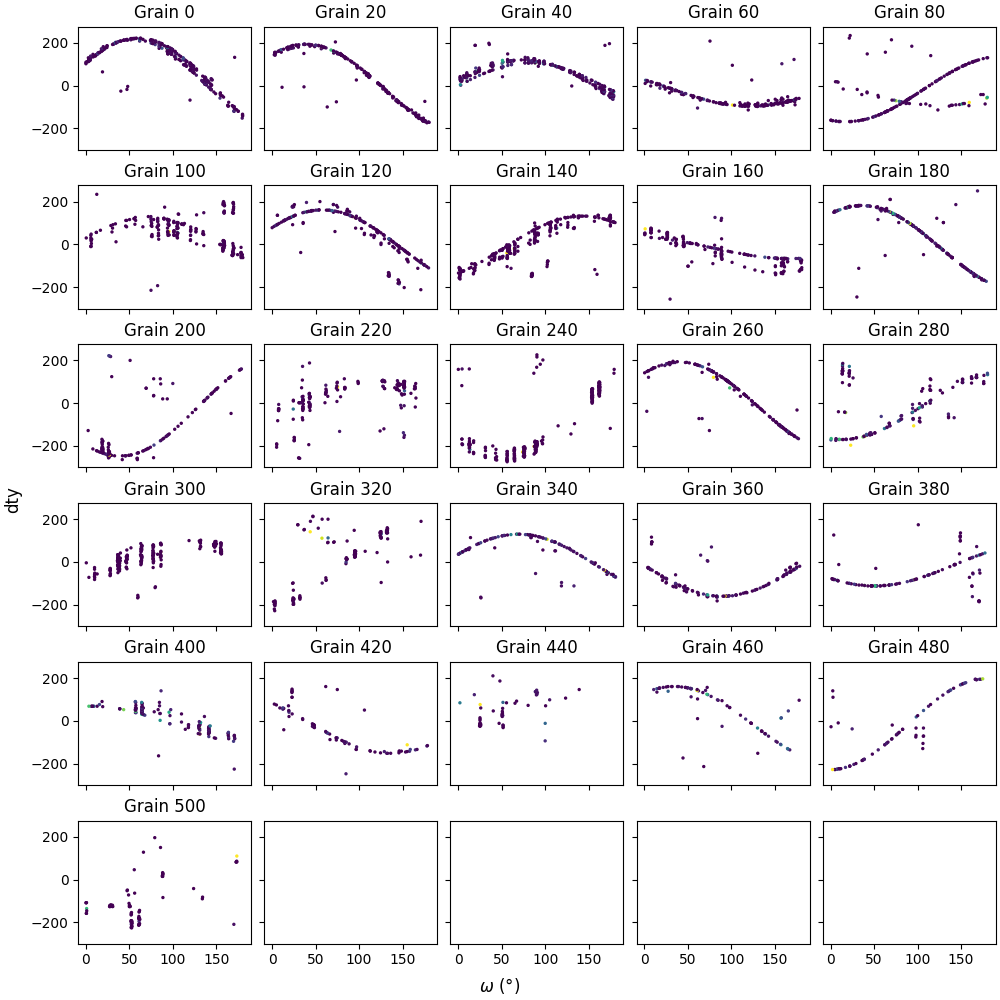

In [18]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Export data

You can not save new indexed grains if there are some existing ones. This cell deletes all existing grains of the phase `phase_str` from the *h5* grain file.

In [19]:
from ImageD11.forward_model import io
io.delete_group_from_h5(ds.grainsfile, group_name = minor_phase_str)

True

In [20]:
ds.save_grains_to_disk(grains, phase_name=minor_phase_str)
ds.save()